In [23]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly as ply
import seaborn as sns
import squarify

In [2]:
pathMain = 'API_19_DS2_en_excel_v2_6002116.xls'
pathGDP =  "API_NY.GDP.MKTP.CD_DS2_en_excel_v2_5994847.xls"
pathGDPcap = "API_NY.GDP.PCAP.CD_DS2_en_excel_v2_5994922.xls"

In [3]:
def initialize_data(main_data_file, gdp_file, gdp_cap_file): 

    # Reads the data file and extracts all the sheets from it
    df_data = pd.read_excel(main_data_file, header=3)
    df_gdp = pd.read_excel(gdp_file, header=3)
    df_gdp_cap = pd.read_excel(gdp_cap_file, header=3)
    df_country_metadata = pd.read_excel(main_data_file, sheet_name='Metadata - Countries')
    df_indicator_metadata = pd.read_excel(main_data_file, sheet_name='Metadata - Indicators')

    # Merged columns from Data and Country MetaData
    df_data_merged = pd.merge(df_data, df_country_metadata, on='Country Code', how='inner')
    df_data_merged = pd.concat([df_data_merged, df_gdp, df_gdp_cap], axis=0).sort_values(by='Country Name', ascending=True)
    df_data_merged = df_data_merged.reset_index()

    # Filling in NaN Regions and IncomeGroups with respective values
    region_list = {}
    income_list = {}
    for country_name in df_country_metadata['TableName'].unique():
        region_list[country_name] = df_country_metadata[df_country_metadata['TableName'] == country_name]['Region'].unique()[0]
        income_list[country_name] = df_country_metadata[df_country_metadata['TableName'] == country_name]['IncomeGroup'].unique()[0]

    for country_name, region in region_list.items():
        df_data_merged.loc[df_data_merged['Country Name'] == country_name, 'Region'] = region
        df_data_merged.loc[df_data_merged['Country Name'] == country_name, 'IncomeGroup'] = region
    
    # Sorting Columns out, changing column positions to start of df and removing unwanted columns
    columns_list = df_data_merged.columns.tolist()
    columns_list.insert(4, columns_list.pop(df_data_merged.columns.get_loc('Region')))
    columns_list.insert(5, columns_list.pop(df_data_merged.columns.get_loc('IncomeGroup')))
    df_data_merged = df_data_merged[columns_list]
    df_data_merged = df_data_merged.drop(columns=['SpecialNotes', 'TableName', 'index'], axis=1)
    
    # Setting Multilevel Index for df (df_country)
    df_country = df_data_merged.set_index(['Country Name', 'Country Code', 'Region', 'IncomeGroup', 'Indicator Code', 'Indicator Name'])

    # Filtering out columns based on Indicators to focus on
    df_country = df_country[df_country.index.get_level_values('Indicator Code').isin(['SP.POP.TOTL','SP.POP.GROW','SP.URB.TOTL.IN.ZS','NV.AGR.TOTL.ZS','EN.ATM.GHGT.ZG','EN.ATM.GHGT.KT.CE','EG.USE.PCAP.KG.OE','EG.USE.ELEC.KH.PC','EG.ELC.PETR.ZS','EG.ELC.NGAS.ZS','EG.ELC.COAL.ZS','EG.ELC.ACCS.ZS','AG.LND.FRST.ZS','AG.LND.FRST.K2','AG.LND.AGRI.ZS','NY.GDP.MKTP.CD','NY.GDP.PCAP.CD'])]
    
    # Filtering out countries of interest
    df_country = df_country[df_country.index.get_level_values('Country Name').isin(['India','China','Bangladesh','Australia','New Zealand','Nigeria','Egypt, Arab Rep.','South Africa','Brazil','Colombia','Argentina','Canada','United States','Germany','Spain','Austria'])]

    # This is where the function to output two dataframes ends
    df_year = df_country.T
    
    return df_country, df_year


In [4]:
dfCountry, dfYear = dataInitialize(pathMain,pathGDP,pathGDPcap)

In [5]:
#Creating TimeSeries for 'GDP (current US$)'. Here I create a sub df (dfTimeSeries) using the dfCountry output from the function
rowLabels =  pd.IndexSlice[:,:,:,:,('NY.GDP.MKTP.CD'),:] 
dfTimeSeries = dfCountry.loc[rowLabels, :]

In [6]:
dfTimeSeries = dfTimeSeries.reset_index()

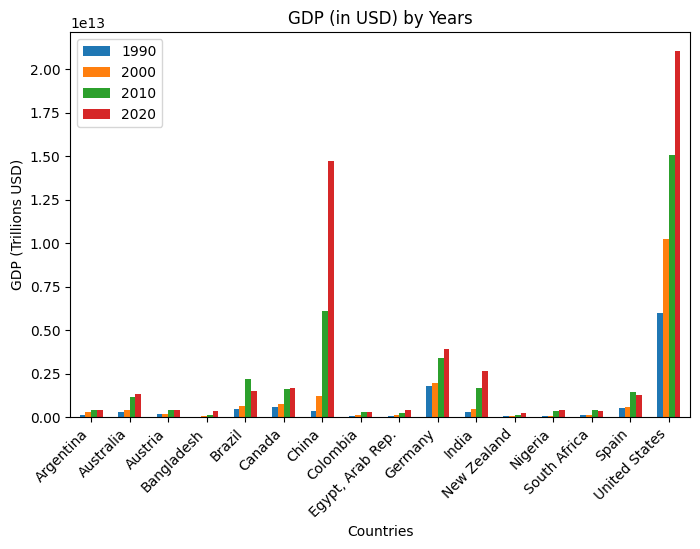

In [51]:
#plot for GDP for each country by years

dfGDP = pd.melt(dfTimeSeries,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
dfGDP.pivot(index='Country Name',columns='variable',values='value').plot(kind='bar',width=0.6,figsize=(8,5) )

plt.xlabel('Countries')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Years')
plt.xticks(rotation=45, ha='right')

plt.legend()
# plt.grid(True)
# plt.show()
plt.savefig('gdp_by_country.png',bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_

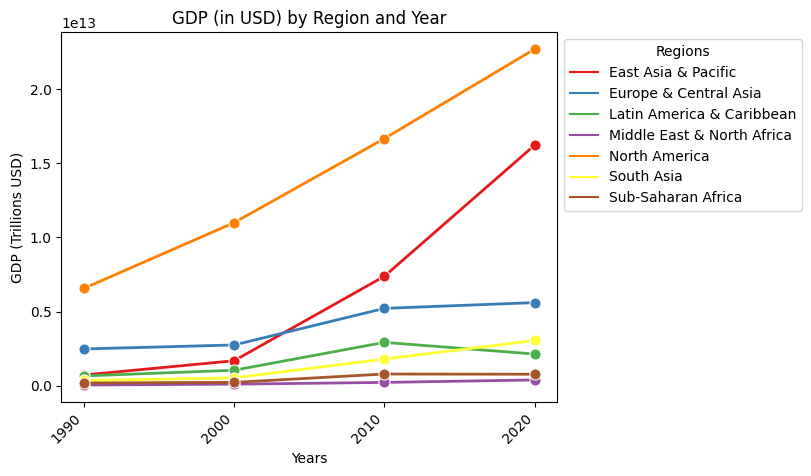

In [50]:
#plot for GDP for Regions by years

dfGDPregion = pd.melt(dfTimeSeries,id_vars=['Region','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
dfGDPregion = dfGDPregion.groupby(['Region','variable'])['value'].sum().reset_index()
defs = dfGDPregion.pivot(index='Region',columns='variable',values='value')
plt.xlabel('Year')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Years')
plt.xticks(rotation=45, ha='right')

plt.legend()
# plt.grid(True)
# plt.show()
sns.lineplot(x='variable', y='value', hue='Region', data=dfGDPregion, marker='o', palette='Set1', markersize=8, linewidth=2)

plt.xlabel('Years')
plt.ylabel('GDP (Trillions USD)')
plt.title('GDP (in USD) by Region and Year')

plt.legend(title='Regions', bbox_to_anchor=(1, 1))
# plt.show()
plt.savefig('gdp_by_region.png',bbox_inches='tight')

In [14]:
#NEW SECTION -- CREATING NEW VISUALIZATIONS FOR THE REST OF THE PAPER
  
dfPopulationTotal = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.POP.TOTL'),:], :]
   
dfPopulationGrowth = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.POP.GROW'),:], :]

dfUrbanPopulation = dfCountry.loc[pd.IndexSlice[:,:,:,:,('SP.URB.TOTL.IN.ZS'),:], :]

dfGDPCapita = dfCountry.loc[pd.IndexSlice[:,:,:,:,('NY.GDP.PCAP.CD'),:], :]

dfEnergy = dfCountry.loc[pd.IndexSlice[:,:,:,:,('EG.USE.ELEC.KH.PC'),:], :]

dfEnergySources = dfCountry.loc[pd.IndexSlice[('United States','China','India','Nigeria','Bangladesh'),:,:,:,('EG.ELC.PETR.ZS','EG.ELC.NGAS.ZS','EG.ELC.COAL.ZS'),:], :]  

dfForestLand = dfCountry.loc[pd.IndexSlice[:,:,:,:,('AG.LND.FRST.K2'),:], :]  

dfgreenhouse = dfCountry.loc[pd.IndexSlice[:,:,:,:,('EN.ATM.GHGT.KT.CE'),:], :]  


In [15]:
dfPopulationTotal = dfPopulationTotal.reset_index()
dfPopulationGrowth = dfPopulationGrowth.reset_index()
dfUrbanPopulation = dfUrbanPopulation.reset_index()
dfGDPCapita.reset_index(inplace=True)
dfEnergy.reset_index(inplace=True)
dfEnergySources.reset_index(inplace=True)
dfgreenhouse.reset_index(inplace=True)
dfForestLand.reset_index(inplace=True)

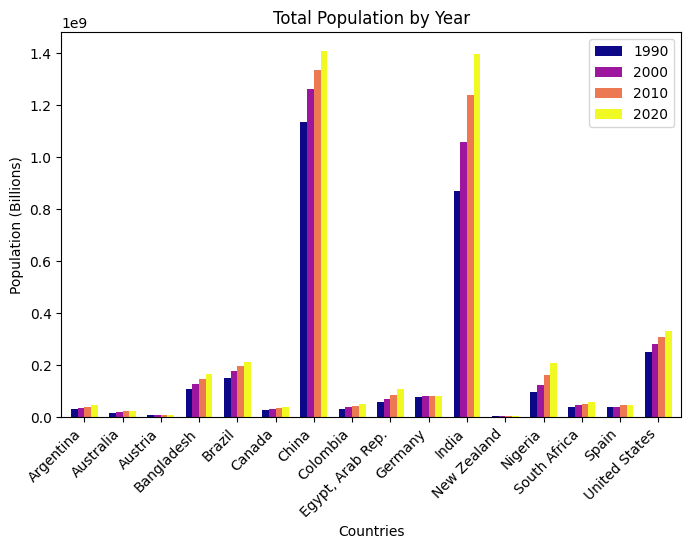

In [52]:
#plot for GDP for Countries by years

dfPopTotal = pd.melt(dfPopulationTotal,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
# dfPopGrowth = dfPopGrowth.groupby(['Country Name','variable'])['value'].sum().reset_index()
dfPopTotal.pivot(index=['Country Name'],columns='variable',values='value').plot(kind='bar',width=0.7,figsize=(8,5),colormap='plasma')

plt.xlabel('Countries')
plt.ylabel('Population (Billions)')
plt.title('Total Population by Year')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.savefig('population_total.png',bbox_inches='tight')
plt.show()

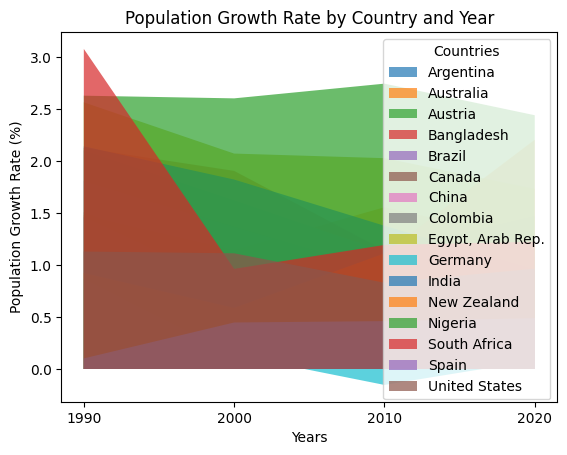

In [53]:
dfPopGrowth = pd.melt(dfPopulationGrowth,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
PopGrowthPivot = dfPopGrowth.pivot_table(index='Country Name',columns='variable',values='value')

# fig, axs = plt.subplots(figsize=(8,6))
# sns.heatmap(PopGrowthPivot, annot=True, fmt=".2f", cmap="gist_heat_r")

# plt.suptitle('Population Growth (%)')
# # axs.set_title('Heatmap')
# axs.set_xlabel('Year')
# axs.set_ylabel('Country')
# plt.tight_layout()
# plt.show()


# Use a filled area plot
for country in PopGrowthPivot.index:
    plt.fill_between(PopGrowthPivot.columns, PopGrowthPivot.loc[country], label=country, alpha=0.7)

plt.xlabel('Years')
plt.ylabel('Population Growth Rate (%)')
plt.title('Population Growth Rate by Country and Year')

plt.legend(title='Countries', bbox_to_anchor=(1, 1))
plt.savefig('population_growth.png',bbox_inches='tight')
plt.show()

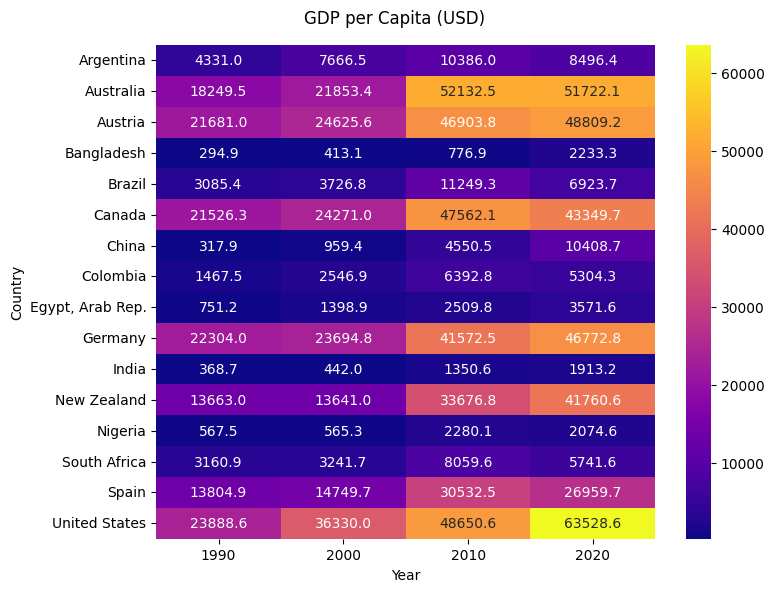

In [20]:
dfGDPcap = pd.melt(dfGDPCapita,id_vars=['Country Name','Indicator Name'],value_vars=[str(x) for x in range(1990,2021,10)])
GDPCapPivot = dfGDPcap.pivot_table(index='Country Name',columns='variable',values='value')

fig, axs = plt.subplots(figsize=(8, 6))
sns.heatmap(GDPCapPivot, annot=True, fmt=".1f", cmap="plasma")

plt.suptitle('GDP per Capita (USD)')
# axs.set_title('Heatmap')
axs.set_xlabel('Year')
axs.set_ylabel('Country')
plt.tight_layout()
plt.show()


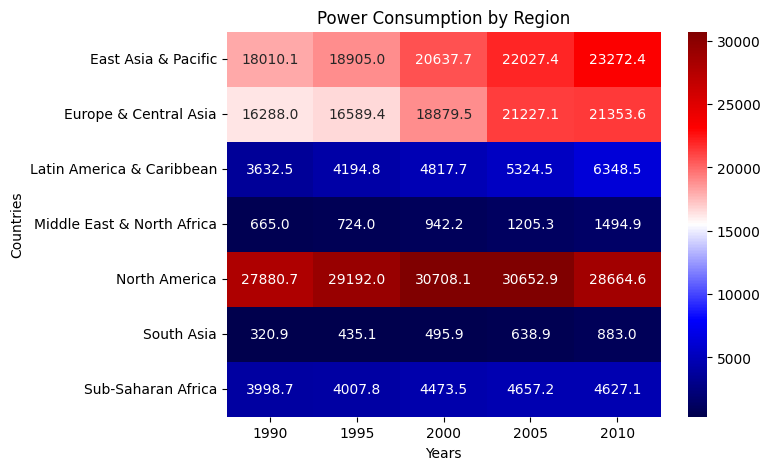

In [56]:
dfEnergyC = pd.melt(dfEnergy,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2015,5)])
dfEnergyC = dfEnergyC.groupby(['Region','variable'])['value'].sum().reset_index()
EnergyPivot = dfEnergyC.pivot_table(index='Region',columns='variable',values='value')

plt.figure(figsize=(7,5))

years = EnergyPivot.columns
values = EnergyPivot.values
pallete = sns.color_palette('Spectral', 9)

# plt.stackplot(years, values, labels=EnergyPivot.index, colors=pallete)
sns.heatmap(EnergyPivot, annot=True, fmt=".1f", cmap="seismic")
plt.xlabel('Years')
plt.ylabel('Countries')
plt.title('Power Consumption by Region')
# plt.legend(loc='lower left')
plt.savefig('power.png',bbox_inches='tight')
# plt.show()




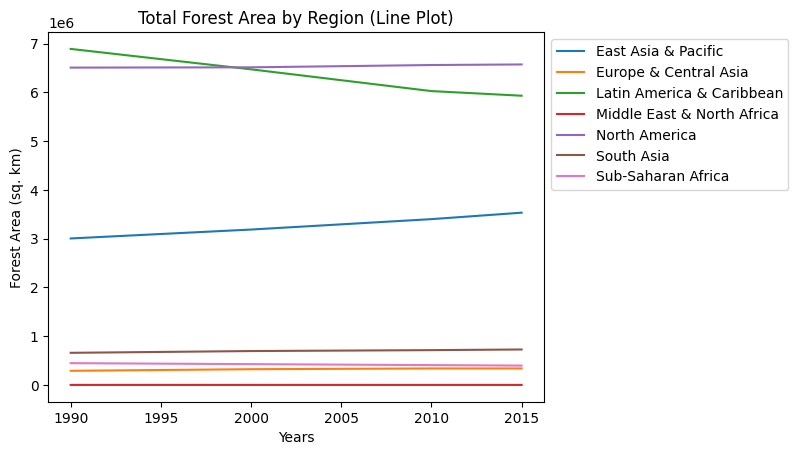

In [57]:
dfForest = pd.melt(dfForestLand,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2016,5)])
dfForest = dfForest.groupby(['Region','variable'])['value'].sum().reset_index()
forestPivot = dfForest.pivot_table(index='Region',columns='variable',values='value')

# plt.figure(figsize=(7,5))

# years = forestPivot.columns
# values = forestPivot.values

# pallete = sns.color_palette('hls', 18)

# plt.stackplot(years, values, labels=EnergyPivot.index,colors=pallete)

# plt.xlabel('Years')
# plt.ylabel('Forest Area (sq. km)')
# plt.title('Total Forest Area by Region')
# plt.legend(loc='lower left')

# plt.show()
for region in forestPivot.index:
    plt.plot(forestPivot.columns, forestPivot.loc[region], label=region)

plt.xlabel('Years')
plt.ylabel('Forest Area (sq. km)')
plt.title('Total Forest Area by Region (Line Plot)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig('forest.png',bbox_inches='tight')
plt.show()


E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
E:\Softwares\Anaconda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

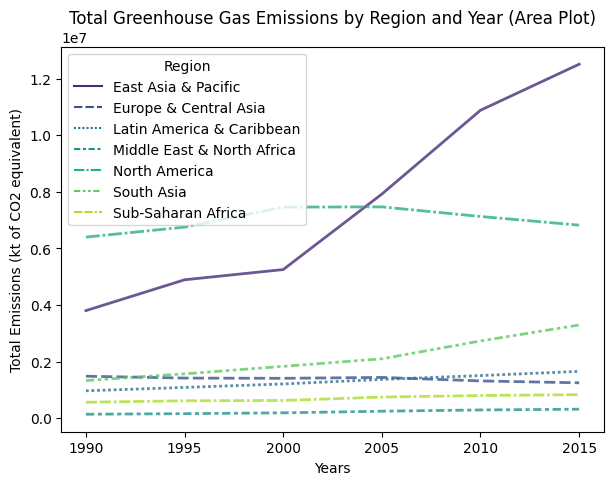

In [58]:
dfGHG = pd.melt(dfgreenhouse,id_vars=['Country Name','Indicator Name','Region'],value_vars=[str(x) for x in range(1990,2016,5)])
dfGHG = dfGHG.groupby(['Region','variable'])['value'].sum().reset_index()
GHGPivot = dfGHG.pivot_table(index='Region',columns='variable',values='value')

plt.figure(figsize=(7,5))

years = GHGPivot.columns
values = GHGPivot.values

pallete = sns.color_palette('Spectral', 7)

# plt.stackplot(years, values, labels=EnergyPivot.index, colors=pallete)

# plt.xlabel('Years')
# plt.ylabel('Total Emissions (kt of CO2 equivalent)')
# plt.title('Total greenhouse gas emissions by Region (kt of CO2 equivalent)')
# plt.legend(loc='lower left')

# plt.show()
palette = sns.color_palette('viridis', n_colors=len(GHGPivot.index))
sns.lineplot(data=GHGPivot.T, palette=palette, lw=2, alpha=0.8)

plt.xlabel('Years')
plt.ylabel('Total Emissions (kt of CO2 equivalent)')
plt.title('Total Greenhouse Gas Emissions by Region and Year (Area Plot)')
plt.savefig('greenhouse.png',bbox_inches='tight')
plt.show()
